Необходимо взять за основу любое предыдущее задание (если нет вычислительных ресурсов то классификация заемщика, если есть то классификация изображений или определение возраста и реализовать стекинг несколькоих моделей). 
В качестве задания используется домашнее задание по определению возраста. 

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, CategoryEncoding,\
                                    Dropout, BatchNormalization, AveragePooling2D, GlobalMaxPool2D
#import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import RootMeanSquaredError
import tensorflow as tf

from tensorflow.keras.models import Model

pd.set_option('display.max_rows', 30)

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)

Virtual devices cannot be modified after being initialized


In [6]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
df = pd.DataFrame(columns=['link', 'age']) ### Создаем пустой Dataframe с колонками Link - ссылка на файл, Age - Возраст

for folder_name in tqdm(os.listdir ('wiki_crop')):
    for file_name in os.listdir('wiki_crop\\'+folder_name):
        #формируем ссылку на изображение
        link = 'wiki_crop\\' + folder_name + '\\' + file_name
        
        #### Распознавание лица с помощью каскадов Хаара
        img = cv2.imread(link)
        if img.shape[0]<96: ### Уберем совсем мелкие и неинформативные изображения
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 6) ## Выставим досточно жесткие условия.
        
        #### Если лицо обнаружено (сумма элементов массива больше 0), то добавляем строку в Dataframe
        if len(faces)>0:
            if len(faces)>1: ### Уберем изображения, на которых выявлено несколько лиц.
                continue
            #определяем возраст
            name = file_name[:-4] #убираем расширение файла из имени
            age_end = name.split('_')[2] # делаем сплит по нижнему подчеркиванию и выбираем последнюю дату
            age_start=str(name.split('_')[1]).split('-')[0] # делаем сплит, выбираем первую дату и далаем сплит по дефису, 
                                                            # выбираем год.
            age_fin = int(age_end)-int(age_start) #Вычисляем возраст
            
            if age_fin>100 or age_fin<0: # Если возраст больше 100 или меньше 0, то выкидываем из набора
                continue
            
            #формируем временный датафрейм
            data = pd.DataFrame({"link": [link],
                                 "age": [age_fin]})
            #Делаем конкатенацию с основным датафреймом.
            df = pd.concat([df,data])

df.to_csv('data_cleaned.csv') #Сохраним в файл полученный Dataframe на случай перезагрузки, чтобы не чистить второй раз )))

100%|██████████| 100/100 [05:44<00:00,  3.44s/it]


In [7]:
df = pd.read_csv('data_cleaned.csv')

In [8]:
df_croped = pd.DataFrame(columns=['link', 'age']) ### Создаем пустой Dataframe с колонками Link - ссылка на файл, Age - Возраст

for index in tqdm(range(len(df))): #
    link = df.iloc[index]['link']
    age = df.iloc[index]['age']
    f_name = df.iloc[index]['link'].split('\\')[-1]
    new_link = 'croped\\' + f_name
    
    img = cv2.imread(link)
    
    if img.shape[0]<150: #уберем совсем мелкие изображения, где распознать лицо затруднительно.
        continue
    
    if img.shape[-1]==3:
        img_new = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_new = img
    
    faces = face_cascade.detectMultiScale(img_new, 
                                          1.05, 
                                          2)
    
    if len(faces)>0: ### Выберем только то, где найдены лица.
        
        if len(faces)>1: ### Если выявлены множественные лица - пропуск
            continue
            
        x, y, w, h = faces[0]
        face_selected = img[y:y+h, x:x+h] ### Выделим лица
        cv2.imwrite(new_link,             ### Сохраним в файл с таким же именем, но в новую папку.
                    face_selected)
        
        data = pd.DataFrame({"link": [new_link],
                             "age": [age]})
        
        df_croped = pd.concat([df_croped,data])
        
df_croped.to_csv('data_croped.csv')

100%|██████████| 26635/26635 [11:17<00:00, 39.30it/s]


In [9]:
df = pd.read_csv ('data_croped.csv')

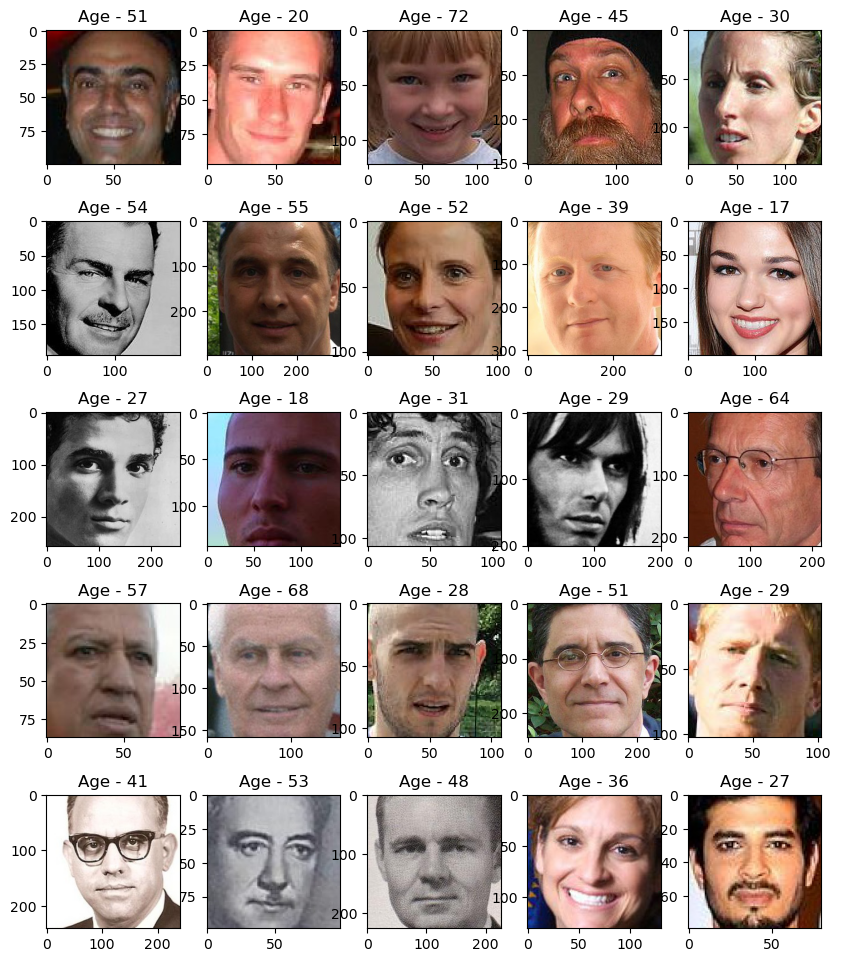

In [10]:
idx = np.random.randint (0,len(df),25)
plt.figure(figsize=(10,12))
for idx in enumerate(idx):
    plt.subplot (5,5,idx[0]+1)
    link = df.iloc[idx[1]]
    image = plt.imread(link[1])
    title = 'Age - ' + str(link[2])
    plt.title (title)
    plt.imshow(image, cmap='gray');

In [11]:
#разобьем датасет на тренировочную и тестовую выборки

train, test = train_test_split(df, random_state = 42, train_size=0.7)

In [12]:
#создадим генератор
train_data=ImageDataGenerator(rescale=1./255.,validation_split=0.3)
test_data=ImageDataGenerator(rescale=1./255.)

In [13]:
TARGET_SIZE = (224,224)

train_generator = train_data.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="link",
y_col="age",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

valid_generator = train_data.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="link",
y_col="age",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

test_generator = test_data.flow_from_dataframe(
dataframe=test,
directory="./",
x_col="link",
y_col="age",
batch_size=32,
seed=42,
shuffle=False,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

Found 8248 validated image filenames.
Found 3534 validated image filenames.
Found 5050 validated image filenames.


Сначала обучим нашу собственную модель

In [14]:
#### Создаем архитектуру модели
model_conv = Sequential()

model_conv.add (Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(224,224,3)))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))

model_conv.add (Conv2D(128, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))

model_conv.add (Conv2D(256, (3,3), padding='same', activation='relu'))

model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))

model_conv.add (Conv2D(512, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))

model_conv.add (Conv2D(512, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))

model_conv.add(GlobalMaxPool2D())

model_conv.add(Dense(1000, activation='relu'))

model_conv.add(Dense(1, activation='linear'))

model_conv.compile(optimizer=Adam(learning_rate=0.00005), loss='mse', metrics=['mae'])

#### Задаем колбэки
lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=2)

#### Обучаем модель
with tf.device('/GPU:0'):   
    history2 = model_conv.fit(train_generator,
                              validation_data=valid_generator,
                              callbacks=[lr_scheduler],
                              epochs=20)

Epoch 1/20
258/258 [==============================] - 32s 106ms/step - loss: 411.7139 - mae: 15.8337 - val_loss: 255.1212 - val_mae: 13.0061 - lr: 5.0000e-05
Epoch 2/20
258/258 [==============================] - 25s 97ms/step - loss: 280.2763 - mae: 13.4309 - val_loss: 259.5010 - val_mae: 13.5585 - lr: 5.0000e-05
Epoch 3/20
258/258 [==============================] - 26s 100ms/step - loss: 272.3994 - mae: 13.2189 - val_loss: 243.8106 - val_mae: 12.8626 - lr: 5.0000e-05
Epoch 4/20
258/258 [==============================] - 27s 103ms/step - loss: 268.5595 - mae: 13.0820 - val_loss: 238.1416 - val_mae: 12.5749 - lr: 5.0000e-05
Epoch 5/20
258/258 [==============================] - 26s 101ms/step - loss: 262.6189 - mae: 12.9316 - val_loss: 239.7414 - val_mae: 12.1454 - lr: 5.0000e-05
Epoch 6/20
258/258 [==============================] - 26s 101ms/step - loss: 257.8311 - mae: 12.8337 - val_loss: 233.1681 - val_mae: 12.5628 - lr: 5.0000e-05
Epoch 7/20
258/258 [==============================] -

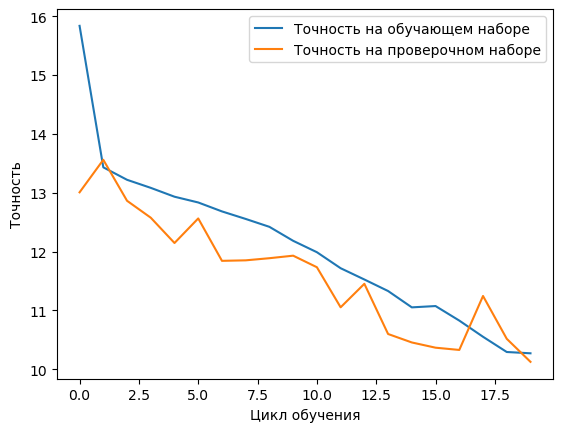

In [15]:
plt.plot(history2.history['mae'], label='Точность на обучающем наборе')
plt.plot(
    history2.history['val_mae'], label='Точность на проверочном наборе')
plt.xlabel('Цикл обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()
pass;

Загрузим предобученную модель VGG16 и обучим на наших данных

In [3]:
from tensorflow.keras.applications import VGG16 

vgg16 = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False) 

for i in vgg16.layers[:-3]:
    i.trainable = False 

# build model 
input = vgg16.layers[-1].output # input is the last output from vgg16 

x = Flatten()(input) 
x = Dense(1000, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='linear')(x) 

# create the model 
vgg16_model = Model(vgg16.input, output, name='VGG16_Model')

In [16]:
vgg16_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

lr_scheduler = ReduceLROnPlateau(factor=0.2, 
                                 patience=5,  
                                 monitor = 'val_mae')

with tf.device('/GPU:0'): 
    history_vgg16 = vgg16_model.fit(train_generator,
                                    validation_data=valid_generator,
                                    callbacks=[lr_scheduler],
                                    epochs=20)

Epoch 1/20
258/258 [==============================] - 43s 152ms/step - loss: 321.3838 - mae: 12.9497 - val_loss: 141.0601 - val_mae: 9.5193 - lr: 5.0000e-04
Epoch 2/20
258/258 [==============================] - 35s 134ms/step - loss: 141.5277 - mae: 9.1761 - val_loss: 118.8798 - val_mae: 8.3774 - lr: 5.0000e-04
Epoch 3/20
258/258 [==============================] - 34s 134ms/step - loss: 121.4014 - mae: 8.4762 - val_loss: 126.9022 - val_mae: 8.4965 - lr: 5.0000e-04
Epoch 4/20
258/258 [==============================] - 36s 140ms/step - loss: 108.6618 - mae: 7.9908 - val_loss: 128.3975 - val_mae: 8.9672 - lr: 5.0000e-04
Epoch 5/20
258/258 [==============================] - 36s 139ms/step - loss: 92.5774 - mae: 7.3405 - val_loss: 102.2994 - val_mae: 7.7622 - lr: 5.0000e-04
Epoch 6/20
258/258 [==============================] - 35s 134ms/step - loss: 79.5237 - mae: 6.8013 - val_loss: 106.6687 - val_mae: 7.9172 - lr: 5.0000e-04
Epoch 7/20
258/258 [==============================] - 34s 133ms/s

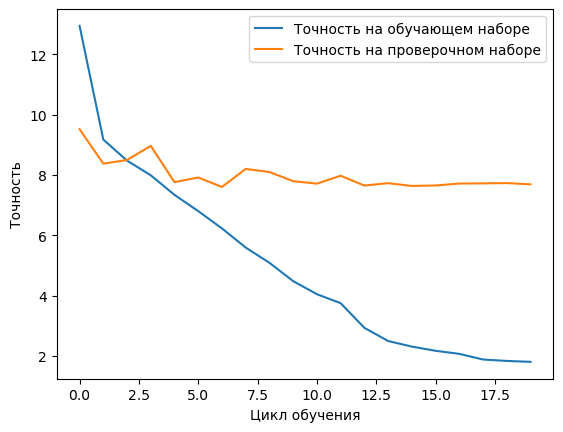

In [17]:
plt.plot(history_vgg16.history['mae'], label='Точность на обучающем наборе')
plt.plot(
    history_vgg16.history['val_mae'], label='Точность на проверочном наборе')
plt.xlabel('Цикл обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()
pass;

Загрузим предобученную модель MobileNet и обучим на наших данных

In [4]:
from tensorflow.keras.applications import MobileNet
mobilenet = tf.keras.applications.mobilenet.MobileNet(input_shape=(224,224,3), weights='imagenet', include_top=False)

In [18]:
for layer in mobilenet.layers[:-5]:
    layer.trainable = False

input = mobilenet.layers[-1].output
x = Flatten()(input) 
x = Dense(1000, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(1, activation='linear')(x) 

# Create the model
mobilenet_model = Model(mobilenet.input, output, name= "Mobilenet_Model")

In [19]:
mobilenet_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

checkpoint_cb_conv = ModelCheckpoint("mobilenet_model.h5", 
                                     monitor = 'val_mae',
                                     save_best_only=True)

lr_scheduler = ReduceLROnPlateau(factor=0.2, 
                                 patience=5,  
                                 monitor = 'val_mae')
with tf.device('/GPU:0'): 
    history_mobilenet = mobilenet_model.fit(train_generator,
                                            validation_data=valid_generator,
                                            callbacks=[checkpoint_cb_conv,lr_scheduler],
                                            epochs=20)


Epoch 1/20
258/258 [==============================] - 19s 68ms/step - loss: 1997.4124 - mae: 39.8640 - val_loss: 1731.4910 - val_mae: 38.4594 - lr: 5.0000e-04
Epoch 2/20
258/258 [==============================] - 16s 62ms/step - loss: 1796.8423 - mae: 39.0579 - val_loss: 1721.9459 - val_mae: 38.3351 - lr: 5.0000e-04
Epoch 3/20
258/258 [==============================] - 16s 60ms/step - loss: 1787.0741 - mae: 38.9321 - val_loss: 1712.3079 - val_mae: 38.2092 - lr: 5.0000e-04
Epoch 4/20
258/258 [==============================] - 16s 60ms/step - loss: 1777.2566 - mae: 38.8060 - val_loss: 1702.6449 - val_mae: 38.0825 - lr: 5.0000e-04
Epoch 5/20
258/258 [==============================] - 15s 60ms/step - loss: 1767.4304 - mae: 38.6790 - val_loss: 1692.9945 - val_mae: 37.9556 - lr: 5.0000e-04
Epoch 6/20
258/258 [==============================] - 16s 60ms/step - loss: 1757.6139 - mae: 38.5524 - val_loss: 1683.3673 - val_mae: 37.8285 - lr: 5.0000e-04
Epoch 7/20
258/258 [==========================

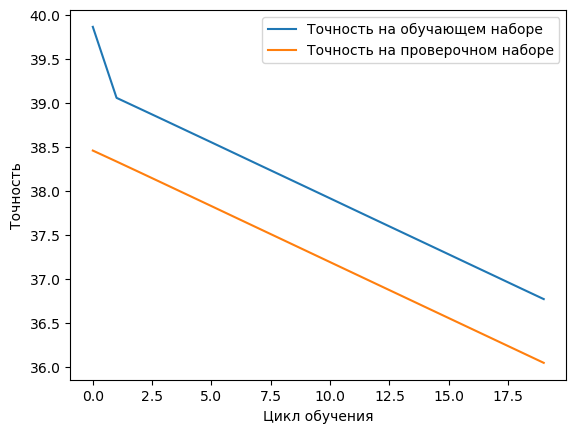

In [20]:
plt.plot(history_mobilenet.history['mae'], label='Точность на обучающем наборе')
plt.plot(
    history_mobilenet.history['val_mae'], label='Точность на проверочном наборе')
plt.xlabel('Цикл обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()
pass;

Соберем из обученных моделей средний ансамбль. 

In [21]:
# get list of models
models = [model_conv, vgg16_model, mobilenet_model] 

In [25]:
from tensorflow.keras.layers import Average, Input

input = Input(shape=(224, 224, 3), name='input')  # input layer

# get output for each input model
outputs = [model(input) for model in models] 

# contenate the ouputs
x = Average()(outputs) 

# add further layers
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x) 

output = Dense(1, activation='linear', name='output')(x) # output layer

# create concatenated model
avg_model = Model(input, output, name= 'Concatenated_Model')

In [26]:
# compile the model 
avg_model.compile(optimizer=Adam(learning_rate=0.00005), loss='mse', metrics=['mae'])

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

# initialize callbacks 
reduceLR = ReduceLROnPlateau(monitor='val_loss', patience= 3, verbose= 1, mode='min', factor=  0.2, min_lr = 1e-6) 

early_stopping = EarlyStopping(monitor='val_loss', patience = 5 , verbose=1, mode='min', restore_best_weights= True) 

callbacks= [reduceLR, early_stopping] 


history_avg_model = avg_model.fit(train_generator, validation_data=valid_generator,
                                      callbacks=callbacks,
                                      epochs=10)


#avg_model.fit(train_gen, steps_per_epoch= TRAIN_STEPS, validation_data=val_gen, validation_steps=VAL_STEPS, epochs= 20, callbacks= callbacks)

Epoch 1/10
258/258 [==============================] - 71s 266ms/step - loss: 1311.1768 - mae: 30.1593 - val_loss: 281.8759 - val_mae: 12.8022 - lr: 5.0000e-05
Epoch 2/10
258/258 [==============================] - 68s 262ms/step - loss: 529.1974 - mae: 17.4244 - val_loss: 153.1871 - val_mae: 9.3935 - lr: 5.0000e-05
Epoch 3/10
258/258 [==============================] - 67s 259ms/step - loss: 344.0750 - mae: 13.9885 - val_loss: 107.1415 - val_mae: 7.8011 - lr: 5.0000e-05
Epoch 4/10
258/258 [==============================] - 67s 258ms/step - loss: 272.3703 - mae: 12.3311 - val_loss: 117.1020 - val_mae: 8.1656 - lr: 5.0000e-05
Epoch 5/10
258/258 [==============================] - 67s 258ms/step - loss: 231.5272 - mae: 11.3472 - val_loss: 114.8269 - val_mae: 8.1135 - lr: 5.0000e-05
Epoch 6/10
258/258 [==============================] - 68s 262ms/step - loss: 194.1938 - mae: 10.4402 - val_loss: 107.1167 - val_mae: 7.7880 - lr: 5.0000e-05
Epoch 7/10
258/258 [==============================] - 69

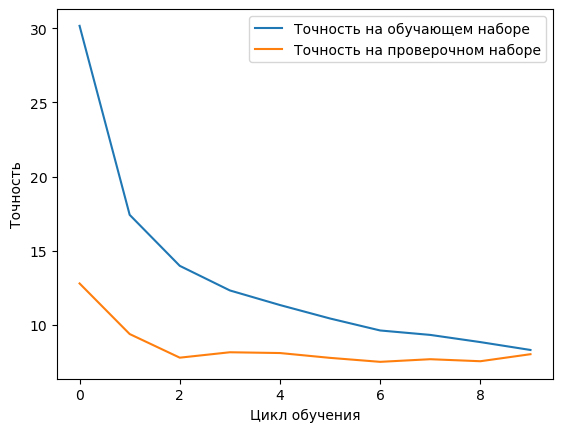

In [28]:
plt.plot(history_avg_model.history['mae'], label='Точность на обучающем наборе')
plt.plot(
    history_avg_model.history['val_mae'], label='Точность на проверочном наборе')
plt.xlabel('Цикл обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()
pass;